Mounted at /content/drive
Found 227 images belonging to 2 classes.
Found 227 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step - accuracy: 0.5216 - loss: 0.6869 - val_accuracy: 0.6344 - val_loss: 0.6709
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 658ms/step - accuracy: 0.5264 - loss: 0.6864 - val_accuracy: 0.6784 - val_loss: 0.6564
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 625ms/step - accuracy: 0.6084 - loss: 0.6724 - val_accuracy: 0.5727 - val_loss: 0.6576
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 561ms/step - accuracy: 0.5888 - loss: 0.6690 - val_accuracy: 0.5947 - val_loss: 0.6472
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 834ms/step - accuracy: 0.6113 - loss: 0.6624 - val_accuracy: 0.6608 - val_loss: 0.6412
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 587ms/step - accuracy: 0.6446 - loss: 0.6529 - val_accuracy: 0.6828 - val_loss: 0.6374
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 596ms/step - accuracy: 0.6621 - loss: 0.6530 - val_accuracy: 0.6476 - val_loss: 0.6334
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 764ms/step - accuracy: 0.6137 - loss: 0.6587 - val_accuracy: 0.5991 - val_loss: 0

Validation Accuracy: 0.69


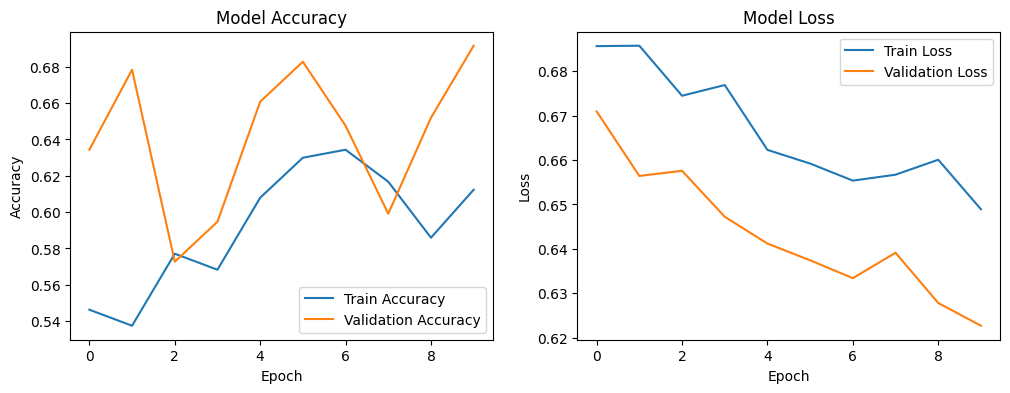

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 793ms/step
              precision    recall  f1-score   support

           0       0.57      0.24      0.34        98
           1       0.60      0.86      0.71       129

    accuracy                           0.59       227
   macro avg       0.59      0.55      0.52       227
weighted avg       0.59      0.59      0.55       227



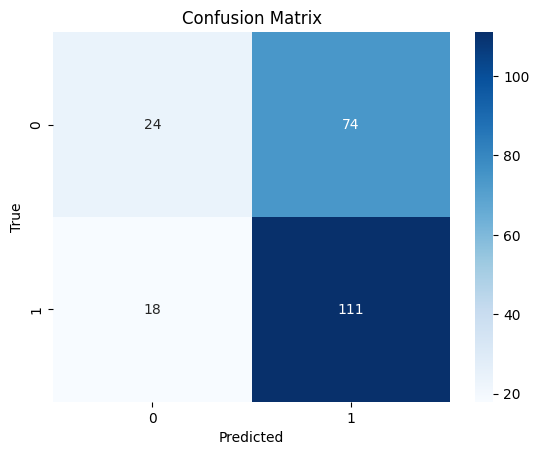

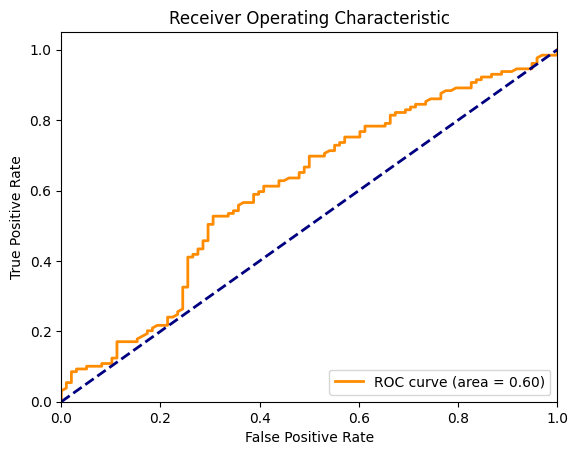

Saving 3.jpg to 3.jpg
User  uploaded file "3.jpg"
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


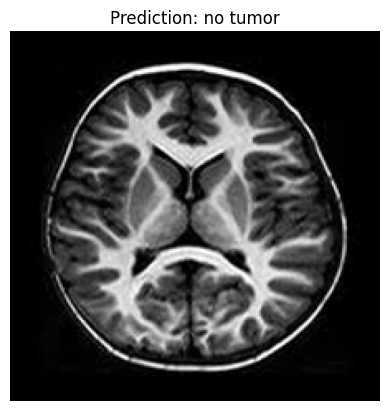

The uploaded image is predicted to be: no tumor


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import cv2
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
from PIL import Image

# Define paths to your dataset
train_dir = '/content/drive/MyDrive/Capstone project'
val_dir = '/content/drive/MyDrive/Capstone project'

# Image data generator for preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

# Load images
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='binary')

# Load the ResNet50 model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy:.2f}')

# ✅ Save the model right after training
model.save("brain_tumor_model.h5")

# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# Predictions
val_generator.reset()
predictions = model.predict(val_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0)

# Classification report
print(classification_report(val_generator.classes, predicted_classes))

# Confusion matrix
conf_matrix = confusion_matrix(val_generator.classes, predicted_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC and AUC
fpr, tpr, thresholds = roc_curve(val_generator.classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


    # Function to predict on a new image
def predict_image(image_path):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((224, 224))  # Resize to match model input
    img_array = np.array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = 'tumor' if prediction[0][0] > 0.5 else 'no tumor'

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {predicted_class}')
    plt.show()

    return predicted_class

# Ask user for input
uploaded = files.upload()  # This will prompt the user to upload an image

# Get the uploaded file name
for filename in uploaded.keys():
    print(f'User  uploaded file "{filename}"')
    result = predict_image(filename)
    print(f'The uploaded image is predicted to be: {result}')

    model.save("brain_tumor_model.h5")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
pip install streamlit pillow tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.0 MB/s eta 0:00:00


In [4]:
import streamlit as st
from PIL import Image
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("brain_tumor_model.h5")

# Function to make prediction
def predict_image(img):
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return 'Tumor' if prediction[0][0] > 0.5 else 'No Tumor'

# Streamlit UI
st.title("Brain Tumor Detection")
st.write("Upload an MRI image to detect if it has a tumor.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    result = predict_image(image)
    st.markdown(f"### Prediction: {result}")


2025-04-09 06:07:13.175 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 06:07:13.255 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-09 06:07:13.256 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 06:07:13.257 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 06:07:13.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 06:07:13.259 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 06:07:13.260 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 06:07:13.261 Thread 'MainThread': mi